In [1]:
#study data
obs   = 'mms1'
year  = '2017'
month = '06'
day   = '08'

In [2]:
#configuration data- directories
basedir       = '/fpiprd1/fpishare/Conrad/'
basedir       = 'c:/Yuggoth/'
obs_path      = basedir+obs+'/'
fast_path     = year+'/'+month+'/'
brst_path     = year+'/'+month+'/'+day+'/'
bpsd_dir      = obs_path+'dsp/fast/l2/bpsd/'+fast_path
epsd_dir      = obs_path+'dsp/fast/l2/epsd/'+fast_path
fgm_dir       = obs_path+'fgm/brst/l2/'+brst_path
fpi_emoms_dir = obs_path+'fpi/brst/l2/des-moms/'+brst_path
fpi_imoms_dir = obs_path+'fpi/brst/l2/dis-moms/'+brst_path

#configuration data - files
fgm_pre       = '%s_fgm_brst_l2_' % (obs,)
fgm_post      = '_v5.92.0.cdf'
fpi_emoms_pre = '%s_fpi_brst_l2_des-moms_' % (obs,)
fpi_imoms_pre = '%s_fpi_brst_l2_dis-moms_' % (obs,)
fpi_post      = '_v3.2.0.cdf'
scpot_pre     = ''
scpot_post    = ''

#configuration - time deltas
des_delta   = 0.031
dis_delta   = 0.151
fgm_delta   = 0.008
scpot_delta = 0.001

In [3]:
epoch_strings = ['20170608133933',
                 '20170608134133',
                 '20170608134403',
                 '20170608134623',
                 '20170608134853',
                 '20170608135003',
                 '20170608135133',
                 '20170608135353',
                 '20170608135623',
                 '20170608135803',
                 '20170608135943',
                 '20170608140143',
                 '20170608140353',
                 '20170608140603',
                 '20170608140813',
                 '20170608141033',
                 '20170608141243',
                 '20170608141453',
                 '20170608141703',
                 '20170608141923',
                 '20170608142133',
                 '20170608142303',
                 '20170608143333',
                 '20170608143453']

In [4]:
###############################################################################
def cbar_position(current_ax,offset,cbar_width):
    #get the tuple describing the lower x,y corner position
    #and the width and height
    x_pos, y_pos, width, height = current_ax.get_position().bounds
    return [x_pos + width + offset, y_pos, cbar_width, height]

###############################################################################
def quiet_axis(ax):
    #ax.set_axis_bgcolor('none')
    ax.set_facecolor('none')
    ax.tick_params(labelcolor='none',top='off',bottom='off',left='off',right='off')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')

In [5]:
def make_Amoms(name):
    Amoms = {'name'   :name,
             'start'  :False,
             'stop'   :False,
             'bulk_vs':np.array([]),
             'epochs' :np.array([]),
             'ergs'   :np.array([]),
             'heats'  :np.array([]),
             'num_es' :np.array([]),          
             'omnis'  :np.array([]),
             'pres_s' :np.array([]),
             'temp_s' :np.array([]),
             'num_brsts':0}

    return Amoms

In [6]:
def munge_moms(epoch_strings,species):
    B       = []
  
    counter = 1
    A = make_Amoms('%s_stride%s' % (species,counter))
    for e in epoch_strings:
        print '*',
        if species == 'des':
            moms       = pycdf.CDF(fpi_emoms_dir+fpi_emoms_pre+e+fpi_post)
            moms_delta = des_delta
        if species == 'dis':
            moms       = pycdf.CDF(fpi_imoms_dir+fpi_imoms_pre+e+fpi_post) 
            moms_delta = dis_delta
        temp_bulk_v = np.asarray(moms['%s_%s_bulkv_gse_brst' % (obs,species)])
        temp_epoch  = np.asarray(moms['Epoch'])
        temp_erg    = np.asarray(moms['%s_%s_energy_brst' % (obs,species)])
        temp_heat   = np.asarray(moms['%s_%s_heatq_gse_brst' % (obs,species)])
        temp_num_e  = np.asarray(moms['%s_%s_numberdensity_brst' % (obs,species)])
        temp_omni   = np.asarray(moms['%s_%s_energyspectr_omni_brst' % (obs,species)])
        temp_pres   = np.asarray(moms['%s_%s_prestensor_gse_brst' % (obs,species)])
        temp_temp   = np.asarray(moms['%s_%s_temptensor_gse_brst' % (obs,species)])
        if A['num_brsts'] == 0:
            A['start']      = temp_epoch[0]
            A['stop']       = temp_epoch[-1]
            A['bulk_vs']    = temp_bulk_v
            A['epochs']     = temp_epoch
            A['ergs']       = temp_erg
            A['heats']      = temp_heat
            A['num_es']     = temp_num_e
            A['omnis']      = temp_omni
            A['pres_s']     = temp_pres
            A['temp_s']     = temp_temp            
            A['num_brsts'] += 1
        elif (temp_epoch[0] - A['stop']).total_seconds() < moms_delta:
            A['stop']       = temp_epoch[-1]
            A['bulk_vs']    = np.vstack((A['bulk_vs'],temp_bulk_v))            
            A['epochs']     = np.hstack((A['epochs'],temp_epoch))
            A['ergs']       = np.vstack((A['ergs'],temp_erg))
            A['heats']      = np.vstack((A['heats'],temp_heat))            
            A['num_es']     = np.hstack((A['num_es'],temp_num_e))
            A['omnis']      = np.vstack((A['omnis'],temp_omni))
            A['pres_s']     = np.vstack((A['pres_s'],temp_pres))
            A['temp_s']     = np.vstack((A['temp_s'],temp_temp))
            A['num_brsts'] += 1
        elif (temp_epoch[0] - A['stop']).total_seconds() > moms_delta:
            B.append(A)
            counter += 1
            A               = make_Amoms('%s_stride%s' % (species,counter))
            A['start']      = temp_epoch[0]
            A['stop']       = temp_epoch[-1]
            A['bulk_vs']    = temp_bulk_v
            A['epochs']     = temp_epoch
            A['ergs']       = temp_erg
            A['heats']      = temp_heat
            A['num_es']     = temp_num_e
            A['omnis']      = temp_omni
            A['pres_s']     = temp_pres
            A['temp_s']     = temp_temp            
            A['num_brsts'] += 1
    B.append(A)
    return B

In [7]:
def make_Afgm(name):
    Afgm = {'name'     :name,
            'start'    :False,
            'stop'     :False,
            'epochs'   :np.array([]),
            'Bgse'     :np.array([]),
            'Bgsm'     :np.array([]),
            'num_brsts':0}

    return Afgm

In [8]:
def munge_fgm(epoch_strings):
    B       = []
    counter = 1
    A       = make_Afgm('fgm_stride%s' % (counter,))
    for e in epoch_strings:
        print '*',
        fgm        = pycdf.CDF(fgm_dir+fgm_pre+e+fgm_post) 
        temp_B_gse = np.asarray(fgm['%s_fgm_b_gse_brst_l2' % (obs,)])
        temp_B_gsm = np.asarray(fgm['%s_fgm_b_gse_brst_l2' % (obs,)])
        temp_epoch  = np.asarray(fgm['Epoch'])
        if A['num_brsts'] == 0:
            A['start']      = temp_epoch[0]
            A['stop']       = temp_epoch[-1]
            A['Bgse']       = temp_B_gse
            A['Bgsm']       = temp_B_gsm
            A['epochs']     = temp_epoch
            A['num_brsts'] += 1
        elif (temp_epoch[0] - A['stop']).total_seconds() < fgm_delta:
            A['stop']       = temp_epoch[-1]
            A['Bgse']       = np.vstack((A['Bgse'],temp_B_gse))            
            A['Bgsm']       = np.vstack((A['Bgsm'],temp_B_gsm))            
            A['epochs']     = np.hstack((A['epochs'],temp_epoch))
            A['num_brsts'] += 1
        elif (temp_epoch[0] - A['stop']).total_seconds() > fgm_delta:
            B.append(A)
            counter += 1
            A               = make_Afgm('fgm_stride%s' % (counter,))
            A['start']      = temp_epoch[0]
            A['stop']       = temp_epoch[-1]
            A['Bgse']       = temp_B_gse
            A['Bgsm']       = temp_B_gsm
            A['epochs']     = temp_epoch
            A['num_brsts'] += 1
    B.append(A)
    return B

In [9]:
Be = munge_moms(epoch_strings,'des')

* * * * * * * * * * * * * * * * * * * * * * * *


In [10]:
Bi = munge_moms(epoch_strings,'dis')

* * * * * * * * * * * * * * * * * * * * * * * *


In [11]:
Bfgm = munge_fgm(epoch_strings)

* * * * * * * * * * * * * * * * * * * * * * * *


In [12]:
des_ergs = Be[0]['ergs'][0,:]
dis_ergs = Bi[0]['ergs'][0,:]

C:\Users\Conrad\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: divide by zero encountered in log10


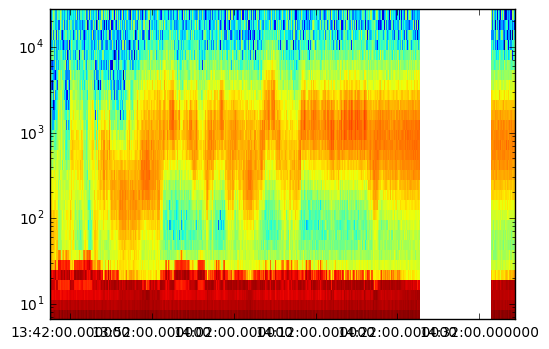

In [13]:
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)


for be in Be:
    Qe = np.ma.masked_invalid(np.log10(be['omnis'])).T
    patch = ax.pcolormesh(be['epochs'],des_ergs,Qe)
ax.set_ylim([des_ergs[0],des_ergs[-1]])
ax.set_yscale('log')

C:\Users\Conrad\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: divide by zero encountered in log10


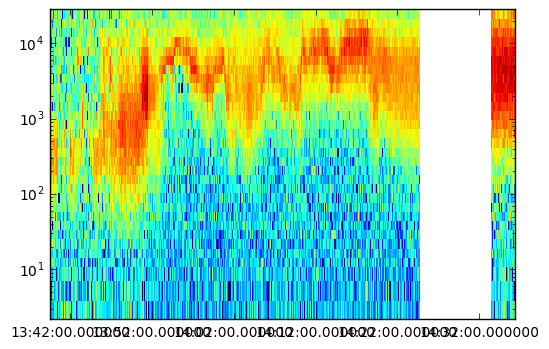

In [14]:
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)


for bi in Bi:
    Qi = np.ma.masked_invalid(np.log10(bi['omnis'])).T
    patch = ax.pcolormesh(bi['epochs'],dis_ergs,Qi)
ax.set_ylim([dis_ergs[0],dis_ergs[-1]])
ax.set_yscale('log')

In [15]:
Bfgm[0].keys()

['num_brsts', 'name', 'Bgse', 'stop', 'epochs', 'start', 'Bgsm']

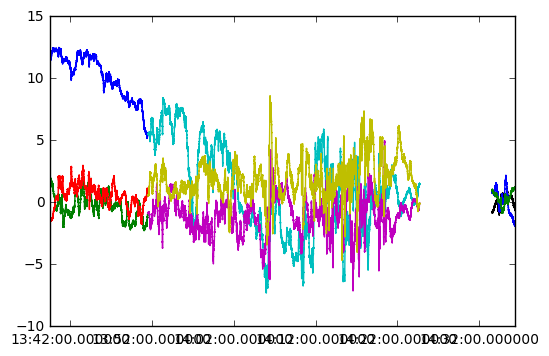

In [16]:
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)

for bf in Bfgm:
    ax.plot(bf['epochs'],bf['Bgse'][:,0])
    ax.plot(bf['epochs'],bf['Bgse'][:,1])
    ax.plot(bf['epochs'],bf['Bgse'][:,2])    
#ax.set_ylim([dis_ergs[0],dis_ergs[-1]])
#ax.set_yscale('log')
#for bf in Bfgm:
    

In [17]:
bpsd_f = bpsd_dir+'mms1_dsp_fast_l2_bpsd_20170608_v2.2.3.cdf'
epsd_f = epsd_dir+'mms1_dsp_fast_l2_epsd_20170608_v0.6.3.cdf'

In [18]:
bpsd       = pycdf.CDF(bpsd_f)
epsd       = pycdf.CDF(epsd_f)
bpsd_Epoch = np.asarray(bpsd['Epoch'])
bpsd_freq  = np.asarray(bpsd['mms1_b_freq'][:])
epsd_Epoch = np.asarray(epsd['Epoch'])
epsd_freq  = np.asarray(epsd['mms1_e_freq'][:])
bpsd_omni  = np.ma.masked_invalid(np.log10(np.asarray(bpsd['mms1_dsp_bpsd_omni_fast_l2']))).T
epsd_omni  = np.ma.masked_invalid(np.log10(np.asarray(epsd['mms1_dsp_epsd_omni']))).T

C:\Users\Conrad\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log10
C:\Users\Conrad\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log10


In [19]:
bpsd.close()
epsd.close()

In [20]:
obs     = 'mms1'
species = 'dis'
counter = 0
data    = []
for e in epoch_strings:
    dis_f = dis_brst_path+dis_pre+e+dis_post
    fgm_f = fgm_brst_path+fgm_pre+e+fgm_post
    dis   = pycdf.CDF(dis_f)
    fgm   = pycdf.CDF(fgm_f)
    temp   = pack_brst_struct(dis,fgm,'mms1','dis')
    data.append(temp)
    print str(counter)+'-',
    counter += 1
    dis.close()
    fgm.close()

NameError: name 'dis_brst_path' is not defined

In [ ]:
fig  = plt.figure(figsize=(16,16))
ax1  = fig.add_subplot(4,1,1)
ax2  = fig.add_subplot(4,1,2,sharex=ax1)
ax3  = fig.add_subplot(4,1,3,sharex=ax1)
ax4  = fig.add_subplot(4,1,4,sharex=ax1)
flag = 0
for d in data:
    if flag == 0:
        ax1.plot(d['fgm_Epoch'],d['b_gse_brst'][:,0],'b-',label='Bx')
        ax1.plot(d['fgm_Epoch'],d['b_gse_brst'][:,1],'g-',label='By')
        ax1.plot(d['fgm_Epoch'],d['b_gse_brst'][:,2],'r-',label='Bz')
        ax1.plot(d['fgm_Epoch'],d['b_gse_brst'][:,3],'k-',label='|B|')        
        ax2.plot(d['dis_Epoch'],d['bulk_v'][:,0],'b-',label='Vx')
        ax2.plot(d['dis_Epoch'],d['bulk_v'][:,1],'g-',label='Vy')
        ax2.plot(d['dis_Epoch'],d['bulk_v'][:,2],'r-',label='Vz')
        flag = 1
    else:
        ax1.plot(d['fgm_Epoch'],d['b_gse_brst'][:,0],'b-')
        ax1.plot(d['fgm_Epoch'],d['b_gse_brst'][:,1],'g-')
        ax1.plot(d['fgm_Epoch'],d['b_gse_brst'][:,2],'r-')
        ax1.plot(d['fgm_Epoch'],d['b_gse_brst'][:,3],'k-')        
        ax2.plot(d['dis_Epoch'],d['bulk_v'][:,0],'b-')
        ax2.plot(d['dis_Epoch'],d['bulk_v'][:,1],'g-')
        ax2.plot(d['dis_Epoch'],d['bulk_v'][:,2],'r-')
        cbpatch3 = ax3.pcolormesh(d['dis_Epoch'],\
                                  d['dis_Energy'][0][0:32],\
                                  np.ma.masked_invalid(np.log10(d['energy_spec'].T)),\
                                  cmap=cmap.jet,\
                                  shading='gouraud')
xmin,xmax = ax1.get_xlim()   

cbpatch4 = ax4.pcolormesh(dsp_Epoch,dsp_freq,dsp_omni,cmap=cmap.jet)

cb3ax = fig.add_axes(cbar_position(ax3,0.01,0.01))
cb4ax = fig.add_axes(cbar_position(ax4,0.01,0.01))

fig.colorbar(cbpatch3,cax=cb3ax,ticks=[3,4,5,6],format=ticker.FormatStrFormatter('$10^{%d}$'))
fig.colorbar(cbpatch4,cax=cb4ax,format=ticker.FormatStrFormatter('$10^{%d}$'))

ax1.set_ylabel('Magnetic Field (nT)\n GSE FGM',fontsize=16)
ax1.legend(fontsize=18)    

ax2.set_ylabel('Ion Bulk Velocity (km/s)',fontsize=16)
ax2.legend(fontsize=18)    

ax3.set_yscale('log')        
ax3.set_ylabel('Energy (eV)')
cb3ax.set_ylabel('keV/(cm^2 s sr keV)')

ax4.set_yscale('log')
ax4.set_ylim([dsp_freq[0],dsp_freq[58]])
ax4.set_xlabel('Epoch',fontsize=16)
ax4.set_ylabel('Frequency (Hz)')
cb4ax.set_ylabel('(V/m)^2/Hz')
ax4.set_xlim([xmin,xmax])


plt.show()   

In [ ]:
last_stop = dt.datetime(2017,6,8,13,30)
for e in epoch_strings:
    fgm = pycdf.CDF(fgm_dir+fgm_pre+e+fgm_post)
    print fgm['Epoch'][0], fgm['Epoch'][-1], (fgm['Epoch'][0]-last_stop).total_seconds()
    last_stop = fgm['Epoch'][-1]